In [1]:
import torch
torch.__version__

'1.11.0'

In [2]:
import mmcv
mmcv.__version__

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


'1.7.1'

In [3]:
import mmseg
mmseg.__version__

'0.30.0'

In [1]:
!wget https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification/resolve/main/multi_temporal_crop_classification_Prithvi_100M.pth -P ./pretrain/

--2023-08-14 21:48:05--  https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification/resolve/main/multi_temporal_crop_classification_Prithvi_100M.pth
huggingface.co (huggingface.co) をDNSに問いあわせています... 2600:9000:26a7:f400:17:b174:6d00:93a1, 2600:9000:26a7:d200:17:b174:6d00:93a1, 2600:9000:26a7:7600:17:b174:6d00:93a1, ...
huggingface.co (huggingface.co)|2600:9000:26a7:f400:17:b174:6d00:93a1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://cdn-lfs.huggingface.co/repos/82/e3/82e32829ca9fbe7bcbec658d90ee95f2316ac16dc01f36a35f3ec12e539c2358/37ed41637eccccec65ca2031324e2c03a4f168e1ea0ea71ad180910589fa018c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27multi_temporal_crop_classification_Prithvi_100M.pth%3B+filename%3D%22multi_temporal_crop_classification_Prithvi_100M.pth%22%3B&Expires=1692276485&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MjI3NjQ4NX19LCJSZXNvdXJjZSI6Im

In [4]:
%cd hls-foundation-os

/workspace/src/hls-foundation-os


## Crop

https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification

In [5]:
import os
os.makedirs('output/crop/', exist_ok=True)
os.makedirs('input/crop/', exist_ok=True)

In [6]:
import tifffile
import cv2
import numpy as np

img = tifffile.imread('../../sample/ROIs1158_spring_s2/s2_1/ROIs1158_spring_s2_1_p30.tif')
print(img.shape, img.dtype)

# 13 --> 6
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
img_band = np.stack([
    img[:, :, 1], img[:, :, 2], img[:, :, 3], # RGB
    img[:, :, 7], img[:, :, 11], img[:, :, 12],
    img[:, :, 1], img[:, :, 2], img[:, :, 3], # RGB
    img[:, :, 7], img[:, :, 11], img[:, :, 12],
    img[:, :, 1], img[:, :, 2], img[:, :, 3], # RGB
    img[:, :, 7], img[:, :, 11], img[:, :, 12],
    ], 
    axis=0) 

print(img_band.shape, img_band.dtype)

# save as tif
tifffile.imwrite('input/crop/ROIs1158_spring_s2_1_p30_crop.tif', img_band)

(256, 256, 13) uint16
(18, 224, 224) uint16


## Config 修正
```python
channel_last=False
``` 
に変更する

In [7]:
!python model_inference.py -config configs/multi_temporal_crop_classification.py \
    -ckpt ../pretrain/multi_temporal_crop_classification_Prithvi_100M.pth \
    -input input/crop/ \
    -output output/crop/ -input_type tif -bands "[0,1,2,3,4,5]"

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
load checkpoint from local path: ../pretrain/multi_temporal_crop_classification_Prithvi_100M.pth
Identified images to predict on: 1
Working on Image 0
Running inference...
Output has shape: (224, 224)
/opt/conda/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Saving output...
/opt/conda/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equa

(224, 224)


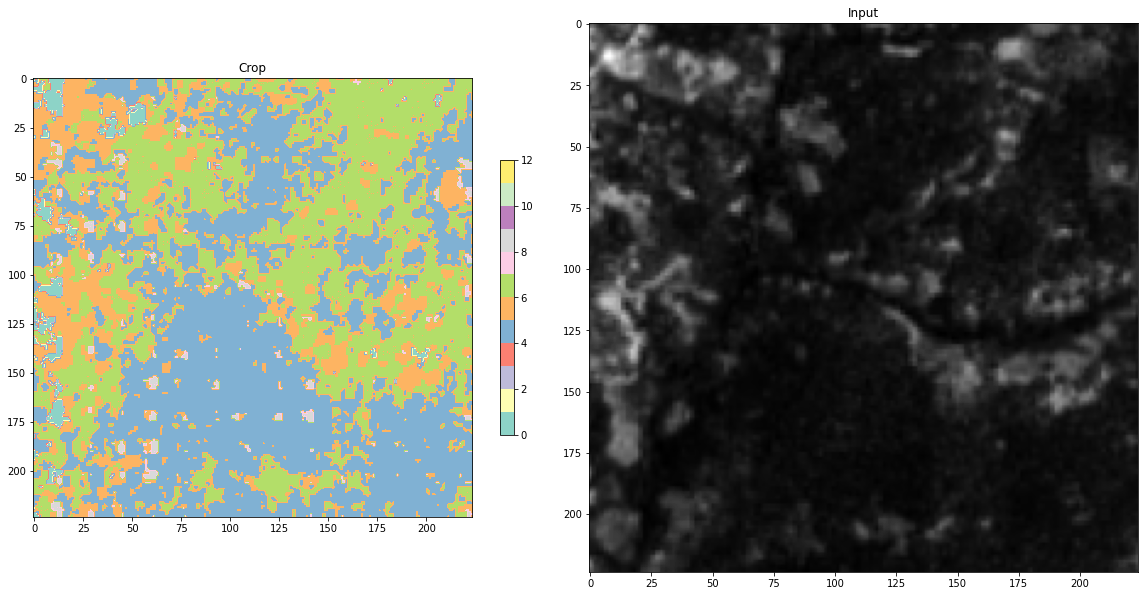

In [8]:
PATH_OUT = f'output/crop/ROIs1158_spring_s2_1_p30_crop_pred.tif'

import matplotlib.pyplot as plt
pred_t0 = tifffile.imread(PATH_OUT)
print(pred_t0.shape)

# plot image
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Crop')
plt.imshow(pred_t0, cmap='Set3', vmin=0, vmax=12)
plt.colorbar(shrink=0.5)

plt.subplot(1, 2, 2)
plt.title('Input')
plt.imshow(img_band[-1], cmap='gray')

# off grid
plt.tight_layout()
plt.grid(False)